In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SequentialSampler

%matplotlib inline

# Convolutional Neural Network for Time Series

## Univariate CNN 

Univarate time series are datasets contains only one sinle series of observations with a temporal ordering. Model need to learn from past observations to predict next value in sequence.

### Dataset

Monthly sunspot dataset describes a monthly count of number of observed sunspots for just over 230 years from 1749 to 1983. Dataset contains 2820 observations. 

You can download data from: https://datamarket.com/data/set/22ti/zuerich-monthly-sunspot-numbers-1749-1983#!ds=22ti&display=line

In [2]:
uni_df = pd.read_csv('datasets/zuerich-monthly-sunspot-numbers-.csv', 
                     sep=';', names=['month', 'observations'], header=0)
uni_df.dropna(inplace=True)
uni_df['month'] = pd.to_datetime(uni_df['month'])
uni_df.set_index('month', inplace=True)
uni_df.head(5)

,observations
month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [3]:
uni_df.shape

(2820, 1)

In [4]:
uni_df.dtypes

observations    float64
dtype: object

The time series is univariate, it can be easly plotted.

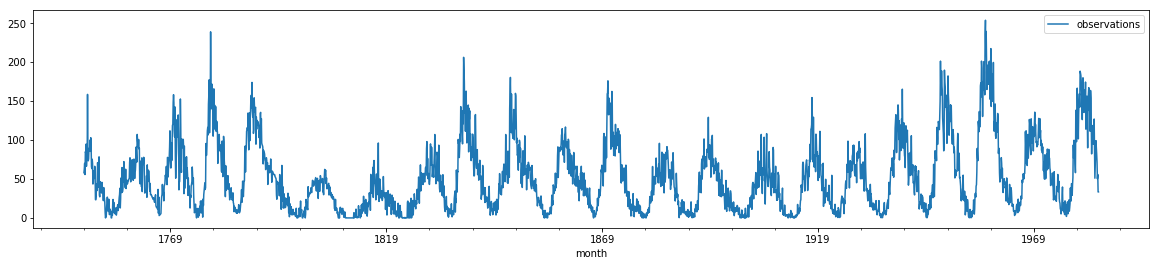

In [5]:
uni_df.plot(figsize=(20, 4))

### Data preparation

PyTorch provides tool for preparing data. It makes code more readable and reusable. 

In [6]:
class SunspotDataset(Dataset):
    def __init__(self, csv_file, lag, transform=None):
        df = pd.read_csv(csv_file, sep=';', names=['month', 'observations'], header=0)
        self.len = df.shape[0]
        self.lag = lag
        self.X, self.y = self.prepare(df.observations.values)
        
    def prepare(self, sequence):
        X, y = list(), list()
        for i in range(self.len):
            end_ix = i + self.lag
            if end_ix > self.len - 1:
                break
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        
        return (X, y)
        
    def __len__(self):
        return int(self.len / self.lag)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return (x, y)
        

 SunspotDataset class can be instantiated and tested.

In [24]:
D_in = 20
csv_file = 'datasets/zuerich-monthly-sunspot-numbers-.csv'
sunspot_dataset = SunspotDataset(csv_file, D_in, 2820)
len(sunspot_dataset)

141

In [25]:
for i in range(len(sunspot_dataset)):
    sample = sunspot_dataset[i]
    print(sample, type(sample[0]))
    if i == 3:
        break

(array([ 58. ,  62.6,  70. ,  55.7,  85. ,  83.5,  94.8,  66.3,  75.9,
        75.5, 158.6,  85.2,  73.3,  75.9,  89.2,  88.3,  90. , 100. ,
        85.4, 103. ]), 91.2) <class 'numpy.ndarray'>
(array([ 62.6,  70. ,  55.7,  85. ,  83.5,  94.8,  66.3,  75.9,  75.5,
       158.6,  85.2,  73.3,  75.9,  89.2,  88.3,  90. , 100. ,  85.4,
       103. ,  91.2]), 65.7) <class 'numpy.ndarray'>
(array([ 70. ,  55.7,  85. ,  83.5,  94.8,  66.3,  75.9,  75.5, 158.6,
        85.2,  73.3,  75.9,  89.2,  88.3,  90. , 100. ,  85.4, 103. ,
        91.2,  65.7]), 63.3) <class 'numpy.ndarray'>
(array([ 55.7,  85. ,  83.5,  94.8,  66.3,  75.9,  75.5, 158.6,  85.2,
        73.3,  75.9,  89.2,  88.3,  90. , 100. ,  85.4, 103. ,  91.2,
        65.7,  63.3]), 75.4) <class 'numpy.ndarray'>


Pytorch allows create custom sampler.

In [9]:
class SequentialSpliter(SequentialSampler):
    def __init__(self, data_source, split_index, is_train):
        super(SequentialSpliter, self).__init__(data_source)
        self.data_source = data_source[data_source <= split_index] if is_train else data_source[split_index < data_source]

Data set needs to be splitted to train and test sets. Torch has good tool from sampling 

In [10]:
# train_sampler = SequentialSpliter(sunspot_dataset, 2000, True)
# test_sampler = SequentialSpliter(sunspot_dataset, 2000, false)

### One-Dimensional Convolutional Neural Network Model (1D CNN)

1D CNN is a model that has convolutional hidden layer that calculates over one dimensional sequence. 

Select device.

In [11]:
device = 'cuda:0'

In [45]:
class OneDCNN(nn.Module):
    def __init__(self, D_in):
        super(OneDCNN, self).__init__()
        self.conv1 = nn.Conv1d(D_in, 16, 1, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64, 50)
        self.fc2 = nn.Linear(50, 4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = x.view(-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
one_dcnn = OneDCNN(D_in)
one_dcnn

OneDCNN(
  (conv1): Conv1d(20, 16, kernel_size=(1,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=4, bias=True)
)

Define a loss function and optimizer

In [46]:
criterion = nn.MSELoss()
optimizer = optim.Adam(one_dcnn.parameters(), lr=0.0001)

Prepare train and test dataloader

In [47]:
sunspot_train_dataloader = DataLoader(sunspot_dataset, batch_size=4, shuffle=False, drop_last=True, num_workers=8)
sunspot_test_dataloader = DataLoader(sunspot_dataset, batch_size=4, shuffle=False, num_workers=8)

Train network

In [48]:
n_epoch = 20
loss_history = list()
for epoch in range(n_epoch):
    running_loss = 0.0
    for i, data in enumerate(sunspot_train_dataloader):
        inputs, labels = data
        inputs = inputs.view(4, D_in, 1).float()
        labels = labels.float()
        optimizer.zero_grad()
        outputs = one_dcnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / i))
    loss_history.append(running_loss)

[1] loss: 2475.409
[2] loss: 2321.119
[3] loss: 2145.110
[4] loss: 1923.465
[5] loss: 1629.498
[6] loss: 1285.277
[7] loss: 949.641
[8] loss: 670.141
[9] loss: 481.676
[10] loss: 376.409
[11] loss: 324.020
[12] loss: 298.282
[13] loss: 284.205
[14] loss: 275.329
[15] loss: 268.578
[16] loss: 263.094
[17] loss: 258.222
[18] loss: 253.946
[19] loss: 249.718
[20] loss: 245.779


The plot below shows loss error.

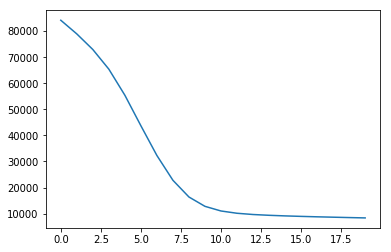

In [49]:
plt.plot(loss_history);

In [ ]:
for i, data in enumerate(sunspot_train_dataloader):
    print(i, data)
    if i == 4:
        break

In [97]:
for i, data in enumerate(sunspot_test_dataloader):
    print(i, data)
    if i == 4:
        break

0 [tensor([[58.0000, 62.6000, 70.0000, 55.7000, 85.0000],
        [62.6000, 70.0000, 55.7000, 85.0000, 83.5000],
        [70.0000, 55.7000, 85.0000, 83.5000, 94.8000],
        [55.7000, 85.0000, 83.5000, 94.8000, 66.3000]], dtype=torch.float64), tensor([83.5000, 94.8000, 66.3000, 75.9000], dtype=torch.float64)]
1 [tensor([[ 85.0000,  83.5000,  94.8000,  66.3000,  75.9000],
        [ 83.5000,  94.8000,  66.3000,  75.9000,  75.5000],
        [ 94.8000,  66.3000,  75.9000,  75.5000, 158.6000],
        [ 66.3000,  75.9000,  75.5000, 158.6000,  85.2000]],
       dtype=torch.float64), tensor([ 75.5000, 158.6000,  85.2000,  73.3000], dtype=torch.float64)]
2 [tensor([[ 75.9000,  75.5000, 158.6000,  85.2000,  73.3000],
        [ 75.5000, 158.6000,  85.2000,  73.3000,  75.9000],
        [158.6000,  85.2000,  73.3000,  75.9000,  89.2000],
        [ 85.2000,  73.3000,  75.9000,  89.2000,  88.3000]],
       dtype=torch.float64), tensor([75.9000, 89.2000, 88.3000, 90.0000], dtype=torch.float64)]
3 [